## Laboratorio 07

- Sara Echeverría 
- Ricardo Méndez   
- Melissa Pérez 

Repositorio: https://github.com/MelissaPerez09/Lab07-CC3104

### Task 01
**Explique la diferencia entre los métodos de aprendizaje de refuerzo basados en valores y en políticas.**
- Los métodos basados en valores buscan aprender una función que estime qué tan buena es una acción en un estado y luego eligen la mejor acción comparando esos valores. A partir de ellas derivan una política que elige las mejores acciones.
- Los métodos basados en políticas aprenden directamente de una política parametrizada que indica cómo actuar en cada estado sin necesidad de comparar entre todas las posibles. 

**¿Por qué los métodos de gradiente de políticas son especialmente útiles para entornos con espacios de acción continua?**
- Porque permiten generar acciones optimizadas en el comportamiento sin tener la necesidad de evaluar y compara un número de acciones. 

### Task 02

In [6]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [7]:
class Policy(nn.Module):
    def __init__(self, stateDim, actionDim):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(stateDim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, actionDim)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return torch.softmax(self.out(x), dim=-1)

In [8]:
class Value(nn.Module):
    def __init__(self, stateDim):
        super(Value, self).__init__()
        self.fc1 = nn.Linear(stateDim, 128)
        self.fc2 = nn.Linear(128, 1)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

In [9]:
env = gym.make("CartPole-v1")
stateDim = env.observation_space.shape[0]
actionDim = env.action_space.n
policy = Policy(stateDim, actionDim)
value = Value(stateDim)
optimizerPolicy = optim.Adam(policy.parameters(), lr=0.001)
optimizerValue = optim.Adam(value.parameters(), lr=0.005)
gamma = 0.99
episodes = 2000
rewardsPerEpisode = []

In [10]:
for ep in range(episodes):
    states = []
    actions = []
    rewards = []
    s = env.reset()[0]
    done = False
    epReward = 0
    while not done:
        sTensor = torch.FloatTensor(s).unsqueeze(0)
        probs = policy(sTensor).squeeze(0)
        dist = torch.distributions.Categorical(probs)
        a = dist.sample()
        sNext, r, done, _, _ = env.step(a.item())
        states.append(sTensor.squeeze(0))
        actions.append(a)
        rewards.append(r)
        s = sNext
        epReward += r
    rewardsPerEpisode.append(epReward)
    returns = []
    g = 0
    for r in reversed(rewards):
        g = r + gamma * g
        returns.insert(0, g)
    returns = torch.FloatTensor(returns)
    if returns.std() > 1e-8:
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)
    for i in range(len(states)):
        baseline = value(states[i])
        advantage = returns[i] - baseline.item()
        logProb = torch.log(policy(states[i].unsqueeze(0)).squeeze(0)[actions[i]])
        lossPolicy = -logProb * advantage
        lossValue = (baseline - returns[i])**2
        optimizerPolicy.zero_grad()
        lossPolicy.backward(retain_graph=True)
        torch.nn.utils.clip_grad_norm_(policy.parameters(), 1.0)
        optimizerPolicy.step()
        optimizerValue.zero_grad()
        lossValue.backward()
        torch.nn.utils.clip_grad_norm_(value.parameters(), 1.0)
        optimizerValue.step()

env.close()

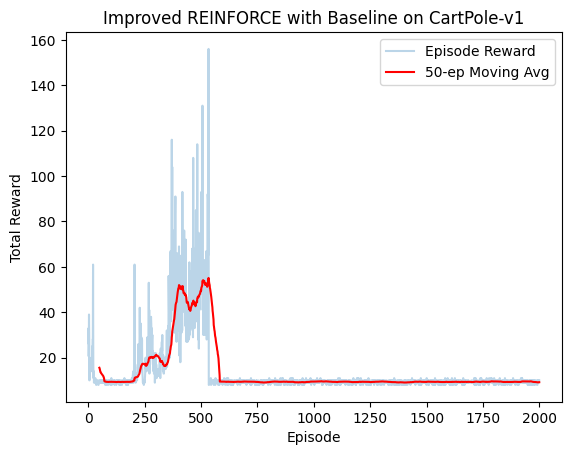

In [11]:
plt.plot(rewardsPerEpisode, alpha=0.3, label="Episode Reward")
window = 50
if len(rewardsPerEpisode) >= window:
    movingAvg = np.convolve(rewardsPerEpisode, np.ones(window)/window, mode="valid")
    plt.plot(range(window-1, episodes), movingAvg, label=f"{window}-ep Moving Avg", color="red")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Improved REINFORCE with Baseline on CartPole-v1")
plt.legend()
plt.show()